In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from glob import glob
import numpy as np
import nibabel as nb
import nibabel.gifti as gifti

In [3]:
from mayavi import mlab
mlab.options.offscreen = True
from tvtk.api import tvtk

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [4]:
img = nb.load('/cifti-data/996782.curvature.32k_fs_LR.dscalar.nii')
mim = img.header.matrix[1]
for idx, bm in enumerate(mim.brain_models):
    print((idx, bm.index_offset, bm.brain_structure))
bm1 = list(mim.brain_models)[0]
lidx = list(bm1.vertex_indices)
bm2 = list(mim.brain_models)[1]
ridx = [bm1.surface_number_of_vertices + val for val in bm2.vertex_indices]
bidx = np.concatenate((lidx, ridx))
print(bidx.shape)

In [5]:
import math

def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    theta = np.asarray(theta)
    axis = axis/math.sqrt(np.dot(axis, axis))
    a = math.cos(theta/2)
    b, c, d = -axis*math.sin(theta/2)
    aa, bb, cc, dd = a*a, b*b, c*c, d*d
    bc, ad, ac, ab, bd, cd = b*c, a*d, a*c, a*b, b*d, c*d
    return np.array([[aa+bb-cc-dd, 2*(bc+ad), 2*(bd-ac)],
                     [2*(bc-ad), aa+cc-bb-dd, 2*(cd+ab)],
                     [2*(bd+ac), 2*(cd-ab), aa+dd-bb-cc]])

axis = [0, 0, 1]
theta = np.pi

In [6]:
inflated = False
split_brain = True

surf = nb.load('/cifti-data/Conte69.L.midthickness.32k_fs_LR.surf.gii') #inflated.32k_fs_LR.surf.gii')
verts_L_data = surf.darrays[0].data
faces_L_data = surf.darrays[1].data

surf = nb.load('/cifti-data/Conte69.R.midthickness.32k_fs_LR.surf.gii') #inflated.32k_fs_LR.surf.gii')
verts_R_data = surf.darrays[0].data
faces_R_data = surf.darrays[1].data

if inflated:
    surf = nb.load('/cifti-data/Conte69.L.inflated.32k_fs_LR.surf.gii')
    verts_L_display = surf.darrays[0].data
    faces_L_display = surf.darrays[1].data
    surf = nb.load('/cifti-data/Conte69.R.inflated.32k_fs_LR.surf.gii')
    verts_R_display = surf.darrays[0].data
    faces_R_display = surf.darrays[1].data
else:
    verts_L_display = verts_L_data.copy()
    verts_R_display = verts_R_data.copy()
    faces_L_display = faces_L_data.copy()
    faces_R_display = faces_R_data.copy()

verts_L_display[:, 0] -= max(verts_L_display[:, 0])
verts_R_display[:, 0] -= min(verts_R_display[:, 0])
verts_L_display[:, 1] -= (max(verts_L_display[:, 1]) + 1)
verts_R_display[:, 1] -= (max(verts_R_display[:, 1]) + 1)

faces = np.vstack((faces_L_display, verts_L_display.shape[0] + faces_R_display))

if split_brain:
    verts2 = rotation_matrix(axis, theta).dot(verts_R_display.T).T
else:
    verts_L_display[:, 1] -= np.mean(verts_L_display[:, 1])
    verts_R_display[:, 1] -= np.mean(verts_R_display[:, 1])
    verts2 = verts_R_display
    

verts_rot = np.vstack((verts_L_display, verts2))
verts = np.vstack((verts_L_data, verts_R_data))
print(verts.shape)
print(faces.shape)

In [7]:
img = nb.load('/cifti-data/speech_pFgA_z_FDR_0.01.nii.gz')

#img = nb.load(('/software/mnt/group_redo/model002/task001/control_co/stats/spm/contrast_8/spmT_0001_threshold.nii.gz'))
#img = nb.load(('/software/mnt/group_redo/model002/task001/control_gt_patients_co/stats/palm/contrast_1/'))

threshold = 2.37 #-np.log10(0.01) #1.3 # 1000
display_threshold = 10 #8000

data = img.get_data()

#img1 = nb.load(('/software/mnt/group_redo/gmodel02/model001/task005/control_gt_patients_co/stats/spm/contrast_1/spmT_0001_threshold.nii.gz'))
#img2 = nb.load(('/software/mnt/group_redo/gmodel02/model001/task005/control_gt_patients_co/stats/spm/contrast_1/spmT_0002_threshold.nii.gz'))
#data = img1.get_data() - img2.get_data()


data[np.isnan(data)] = 0
aff = img.affine
indices = np.round((np.linalg.pinv(aff).dot(np.hstack((verts, 
                                              np.ones((verts.shape[0], 1)))).T))[:3, :].T).astype(int)
scalars2 = data[indices[:, 0], indices[:, 1], indices[:, 2]]
scalars2[np.abs(scalars2) < threshold] = 0.
scalars = np.zeros(verts.shape[0])
scalars[bidx] = scalars2[bidx]

print((scalars.min(), scalars.max()))
negative = positive = False
if np.any(scalars < 0):
    negative = True
if np.any(scalars > 0):
    positive = True

nlabels = 2
if negative and positive:
    maxval = max(-scalars.min(), scalars.max())
    #if maxval > display_threshold:
    maxval = display_threshold
    vmin = -maxval
    vmax = maxval
    nlabels = 3
elif negative:
    vmin = scalars.min()
    #if vmin < -display_threshold:
    vmin = -display_threshold
    vmax = 0
elif positive:
    vmax = scalars.max()
    #if vmax > display_threshold:
    vmax = display_threshold
    vmin = 0
else:
    vmin = 0
    vmax = display_threshold
print((threshold, vmin, vmax, nlabels))

In [8]:
dual_split = False

fig1 = mlab.figure(1, bgcolor=(0, 0, 0))
mlab.clf()
mesh = tvtk.PolyData(points=verts_rot, polys=faces)
mesh.point_data.scalars = scalars
mesh.point_data.scalars.name = 'scalars'
surf = mlab.pipeline.surface(mesh, colormap='autumn', vmin=vmin, vmax=vmax)
if dual_split:
    verts_rot_shifted = verts_rot.copy()
    verts_rot_shifted = rotation_matrix(axis, theta).dot(verts_rot_shifted.T).T
    verts_rot_shifted[:, 2] -= (np.max(verts_rot_shifted[:, 2]) - np.min(verts_rot_shifted[:, 2]))
    verts_rot_shifted[:, 0] -= np.max(verts_rot_shifted[:, 0])
    mesh2 = tvtk.PolyData(points=verts_rot_shifted, polys=faces)
    mesh2.point_data.scalars = scalars
    mesh2.point_data.scalars.name = 'scalars'
    surf2 = mlab.pipeline.surface(mesh2, colormap='autumn', vmin=vmin, vmax=vmax)
colorbar = mlab.colorbar(surf, nb_labels=nlabels) #, orientation='vertical')
lut = surf.module_manager.scalar_lut_manager.lut.table.to_array()

if negative and positive:
    half_index = int(lut.shape[0] / 2)
    index =  int(half_index * threshold / vmax)
    lut[(half_index - index + 1):(half_index + index), :] = 192
    lut[(half_index + index):, :] = 255 * plt.cm.autumn(np.linspace(0, 255, half_index - index).astype(int))
    lut[:(half_index - index), :] = 255 * plt.cm.cool(np.linspace(0, 255, half_index - index).astype(int))
elif negative:
    index =  int(lut.shape[0] * threshold / abs(vmin))
    lut[(lut.shape[0] - index):, :] = 192
    lut[:(lut.shape[0] - index), :] = 255 * plt.cm.cool(np.linspace(0, 255, lut.shape[0] - index).astype(int))
elif positive:
    index =  int(lut.shape[0] * threshold / vmax)
    lut[:index, :] = 192
    lut[index:, :] = 255 * plt.cm.autumn(np.linspace(0, 255, lut.shape[0] - index).astype(int))
else:
    lut[:, :] = 192
lut[:, -1] = 255

surf.module_manager.scalar_lut_manager.lut.table = lut
if dual_split:
    surf2.module_manager.scalar_lut_manager.lut.table = lut
surf.module_manager.scalar_lut_manager.show_scalar_bar = False
surf.module_manager.scalar_lut_manager.show_legend = False
surf.module_manager.scalar_lut_manager.label_text_property.font_size = 10
surf.module_manager.scalar_lut_manager.show_scalar_bar = True
surf.module_manager.scalar_lut_manager.show_legend = True
mlab.draw()

translate = [0, 0, 0]
if inflated:
    zoom = -700
else:
    zoom = -600
if dual_split:
    if inflated:
        translate = [0,   0, -104.01467148]
    else:
        translate = [0,  0, -54.76305802]        
    if inflated:
        zoom = -750
    else:
        zoom = -570
    
mlab.view(0, 90.0, zoom, translate)
#fig1.scene.save_to_clipboard()
mlab.savefig('test_offscreen2.png', figure=fig1, magnification=2)

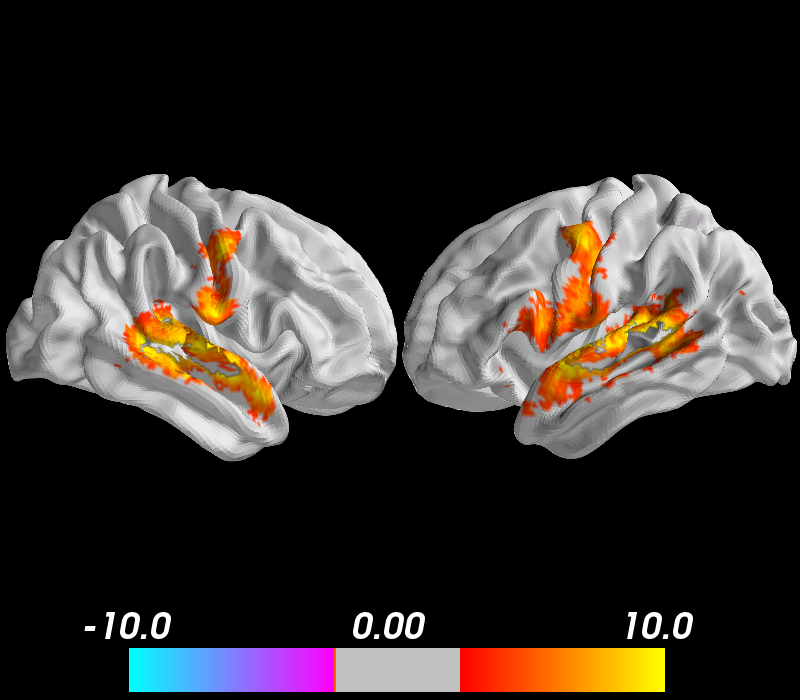

In [9]:
from IPython.display import Image
Image('test_offscreen2.png')